# In Which We Try And Make The Fitness Faster

The bottleneck in our optimization is the time to evaluate the fitness
(and to a less controllable extent, the number of times we must evaluate it).
But, for the moment, fitness time seems to be the easier multiplier to go after.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
if 'thesis.Flight' in sys.modules: del sys.modules['thesis.Flight']

from thesis.ThesisCraft import craft
from thesis.Flight import Flight
from thesis.Trajectory import DeltaThetaZScheduleTrajectory

if 'thesis.EvalHelper' in sys.modules: del sys.modules['thesis.EvalHelper']
if 'thesis.Scenario' in sys.modules: del sys.modules['thesis.Scenario']
plt.rcParams.update({'font.size':16})

from thesis.EvalHelper import Judge
from thesis.Scenario import Scenario

scene = Scenario()
#scene.addRandomGroundUsersUniformCircular(5, r = 5000)
for x in range(-2000, 2001, 500):
    for y in range(-2000, 2001, 500):
        scene.addUser(vector((x, y, 0)))

judge = Judge(scene, craft)


scene.render(size=50000)

Mass is 85.85 kg (50.16 kg struct, 15.50 kg bat)


Graphics3d Object

In [3]:
%load_ext snakeviz

In [52]:
if 'thesis.trajectory.SplineyTrajectory' in sys.modules: del sys.modules['thesis.trajectory.SplineyTrajectory']
if 'thesis.optimize.functions' in sys.modules: del sys.modules['thesis.optimize.functions']
from thesis.optimize.functions import (
  SplineyFitnessHelper, batteryReward, throughputReward, throughputPenalty,
  energyPenalty, gravityReward, radiusPenalty, altitudePenalty, energyPenalty,
  speedPenalty, thrustPenalty
)
times = pd.date_range(start = '2020-11-28T06', end = '2020-11-29T06', freq='10S', tz='America/Detroit').to_series()

template = [2000, 0.1, 0.5, 0.5, 0.5, 0.5] + [
    0.4, 1800.1, 0, 5, 5,
    1800.3, 0.2, 3*pi/2, 5, 5,
    0.2, -1800.3, pi, 5, 5,
    -1800.1, 0.4, pi / 2, 5, 5,
] * numPoints
offsets = [100, 0.1, 0.1, 0.1, 0.1, 0.1] + [5, 5, 0.05, 0.25, 0.25] * 4 * numPoints

# Fix up SageMath numbers
template = list(map(float, template))
offsets = list(map(float, offsets))

bounds = [(0, 9000)] + [
  (0.01, 1)
] * 5 + [
  (-1500, 1500),
  (-1500, 1500),
  (1000, 10000),
  (None, None), # TODO make a proper distance formula for direction
  (0, 12),
  (0, 12),
] * 4 * numPoints

def createParticle(i):
    if i == 0:
      return template

    # This is kinda silly
    #np.random.seed(random.randint(0,99999999))
    at = template.copy()
    for i in range(len(template)):
      off = offsets[i % len(offsets)]
      at[i] += np.random.uniform(off / 2, off * 2)
    return at
  
helper = SplineyFitnessHelper(
  judge, craft, times,
  expr = [
    #batteryReward(),
    #gravityReward() * 0.5L,
    radiusPenalty(2000) * 1e-6L,
    altitudePenalty(1000, 10000),
    throughputReward() / 1e6L / len(scene.users),
    # Here is where we would put our budget
    energyPenalty(-500, gravityCoeff = 1.0),
    thrustPenalty(hi = 100),
    speedPenalty(lo = 6, hi = 25)
  ],
  desiredDuration = 24*3600,
  zMode = 'absolute'
)

In [41]:
%%timeit
t = 3*3.14159/2
c = np.cos(t)
s = np.sqrt(1 - np.sin(t)**2)
R = np.array([[c, -s], [s, c]])
R.dot(np.array([1, 0]))

53.6 µs ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [34]:
%%timeit
from thesis.optimize.BaseOptimizer import Vector
Vector([1, 0]).rotate(3.14159)

5.99 µs ± 5.75 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [50]:
%%timeit
if 'thesis.trajectory.SplineyTrajectory' in sys.modules: del sys.modules['thesis.trajectory.SplineyTrajectory']
from thesis.trajectory.SplineyTrajectory import subSolve

subSolve([1, 2, -1, 0], [4, 5, -1, 0.2], True)

322 µs ± 3.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [47]:
%%timeit
if 'thesis.trajectory.SplineyTrajectory' in sys.modules: del sys.modules['thesis.trajectory.SplineyTrajectory']
from thesis.trajectory.SplineyTrajectory import subSolve2

subSolve2([1, 2, -1, 0], [4, 5, -1, 0.2], True)

406 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [53]:
%%snakeviz
baselineVec = createParticle(1)
helper.getFitness(initial_charge = 0.5, debug=True)(baselineVec)

TypeError: Too close! 2.84,3.40<20.00

In [15]:
list(map(lambda x: x + 2, [1, 5]))

[3, 7]

In [6]:
%%snakeviz
if 'thesis.ThesisCraft' in sys.modules: del sys.modules['thesis.ThesisCraft']
if 'thesis.Aircraft' in sys.modules: del sys.modules['thesis.Aircraft']

from thesis.ThesisCraft import craft

times = pd.date_range(start = '2020-11-28T08', end = '2020-11-30T08', freq='120S', tz='America/Detroit').to_series()
poses = flight.toPoses(times)
solar = craft.calcSolarPower(poses, 36, -84)
charges = craft.calcBatteryCharge(poses, solar, 15.5*650, constant_draw = 109)

Mass is 85.85 kg (50.16 kg struct, 15.50 kg bat)
 
*** Profile stats marshalled to file '/tmp/tmpykifq460'. 
Embedding SnakeViz in this document...


In [134]:
%%timeit
craft.calcBatteryCharge(poses, solar, 15.5*650, constant_draw = 109)

277 ms ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(0, 15112.5000000000)

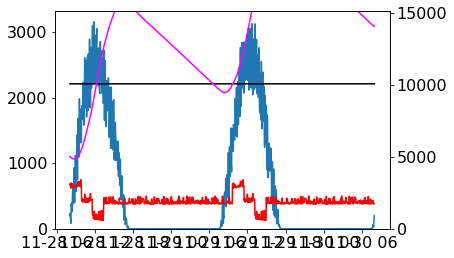

In [141]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
dt = 120

# Power
draw = 109
power = poses.power + draw
ax1.plot(solar.index, solar)
ax1.plot(poses.power + draw, color='red')

# Energy
bat_cap = 15.5*650
ax2.plot(pd.Series(bat_cap, index=solar.index), color='black')

P = (solar - power) * dt / 3600
energy = np.cumsum(P) + 0.5 * bat_cap

# Clamping time
# while np.any(energy > bat_cap):
#     idx_cap = np.argmax(energy > bat_cap)
    
#     if idx_cap == 0:
#         raise TypeError('woops?')
        
#     clipping = energy[idx_cap]
#     down = np.argmax(P[idx_cap] < 0)
    
#     energy[idx_cap:idx_cap + down] = bat_cap
#     energy[idx_cap + down] = np.cumsum(P) + bat_cap

ax2.plot(poses.index, energy, color='magenta')

# Set bounds
ax1.set_ylim((0, None))
ax2.set_ylim((0, 15.5*650*1.5))


In [232]:
%%timeit
power = poses.power + draw
p = np.array(solar - power) * dt / 3600
p[p > 0] *= craft._efficiency['bat_charging']
p[p < 0] *= craft._efficiency['bat_discharging']

e = np.cumsum(p) + 0.5 * bat_cap - p[0]
#e=np.insert(e, 0, 0.5 * bat_cap)

# l = len(charges.index)
# tl = charges.index[l-1]

# p = p[:l]
# e = e[:l]
# c = charges[:tl]
# idx = solar.index[:l]



erem = e
prem = p

while any(erem > bat_cap):
    idx1 = np.argmax(erem > bat_cap)
    cut = np.argmax(prem[idx1:] < 0) + idx1
    # We don't come back down
    if cut == idx1: break
    erem = erem[cut:]
    prem = prem[cut:]
    erem[:] = np.cumsum(prem) + bat_cap
    
e[e > bat_cap] = bat_cap

# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
    
# ax1.plot(idx, e, color='red')
# ax1.plot(c, color='green')

# ax2.plot(e - c, color='orange')
# ax2.set_ylim(-50, 50)
#ax2.plot(idx, p)

879 µs ± 3.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [150]:
a=np.arange(50)
b = a[5:]
b += 10
a, b

(array([ 0,  1,  2,  3,  4, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]))

In [ ]:
%%timeit
idx = pd.MultiIndex.from_product([poses.index, [i for i in range(len(scene.users))]], names=['time', 'user'])
frame = pd.DataFrame(index=idx, columns=['throughput'], dtype='float64')

In [ ]:
%%timeit
frame.copy()
#frame.throughput.loc[:,4L] = 32
#frame.throughput

In [ ]:
%%timeit
a = []
for i in range(5):
    a.append(np.random.uniform(0, 1, 50))


#idx = pd.MultiIndex.from_product([np.arange(0, 50), np.arange(0, 5)], names=['time', 'user'])
frame = pd.DataFrame(np.transpose(a))
frame

In [ ]:
%%timeit
a = []
frame = pd.DataFrame(index=pd.RangeIndex(0, 50), columns=np.arange(5))
for i in range(5):
    frame[i] = np.random.uniform(0, 1, 50)


# #idx = pd.MultiIndex.from_product([np.arange(0, 50), np.arange(0, 5)], names=['time', 'user'])
# frame = pd.DataFrame(np.transpose(a))
frame

In [ ]:
%%timeit
a = []
for i in range(5):
    a.append(np.random.uniform(0, 1, 60))

times = pd.date_range(start = '2020-11-28T08', end = '2020-11-28T08:59', freq='60S', tz='America/Detroit').to_series()

idx = pd.MultiIndex.from_product([times, np.arange(0, 5)], names=['time', 'user'])
#frame = pd.DataFrame(np.transpose(a), index=times)
#frame = pd.DataFrame(index=idx, data=frame.stack(), columns=['throughput'])
#frame = frame.set_index(idx)
#frame

#pd.DataFrame(index=idx)

In [255]:
%%timeit
a=np.arange(0,10000)
b=np.arange(0,10000)
c={}
c[tuple(a)]=32
c[tuple(b)]=54
c

2.28 ms ± 24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [268]:
cachy = None

In [278]:
#%%timeit
import pvlib
cachy = None
if cachy is None:
    cachy = {}
    
altMin, altMax = 1000, 10000
tz, name = 'America/Detroit', 'Michigan'
latitude = 36
longitude = -84

if (altMin, altMax) not in cachy:
    alt = np.arange(altMin, altMax)
    loc = pvlib.location.Location(latitude, longitude, tz, alt, name)
    cachy[(altMin, altMax)] = loc.get_solarposition(alt)
    

altitude = poses.z

cachy[(altMin, altMax)]

# Compute solar position parameters for each timeslot
# ephem_data = loc.get_solarposition(poses.index)
# # Compute irradiation data for each timeslot
# irrad_data = loc.get_clearsky(poses.index, solar_position=ephem_data)

# #irrad_data.plot()

# poses.z.describe()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
1970-01-01 00:00:00.000001000,107.305806,107.305806,-17.305806,-17.305806,253.697836,-3.269007
1970-01-01 00:00:00.000001001,107.305806,107.305806,-17.305806,-17.305806,253.697836,-3.269007
1970-01-01 00:00:00.000001002,107.305806,107.305806,-17.305806,-17.305806,253.697836,-3.269007
1970-01-01 00:00:00.000001003,107.305806,107.305806,-17.305806,-17.305806,253.697836,-3.269007
1970-01-01 00:00:00.000001004,107.305806,107.305806,-17.305806,-17.305806,253.697836,-3.269007
...,...,...,...,...,...,...
1970-01-01 00:00:00.000009995,107.305809,107.305809,-17.305809,-17.305809,253.697836,-3.269007
1970-01-01 00:00:00.000009996,107.305809,107.305809,-17.305809,-17.305809,253.697836,-3.269007
1970-01-01 00:00:00.000009997,107.305809,107.305809,-17.305809,-17.305809,253.697836,-3.269007
1970-01-01 00:00:00.000009998,107.305809,107.305809,-17.305809,-17.305809,253.697836,-3.269007
